# Transfer learning with TensorFlow Part1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
  1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
  2. Can leverage a working neural network architeture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using gpu?
!nvidia-smi

Thu Jul  6 05:57:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data



In [2]:
# Get data (10% of 10 food classes from food101)
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-06 05:57:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.9MB/s    in 4.5s    

2023-07-06 05:57:18 (35.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10percent data directory and list number of files
for dirpath , dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Visualize the images with helper function
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
  """
  Returns the random image
  """
  # setup thr target directory(view images from here)
  target_folder = target_dir + target_class

  # get random image
  random_image = random.sample(os.listdir(target_folder),1)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of image
  plt.show()


Image shape: (512, 512, 3)


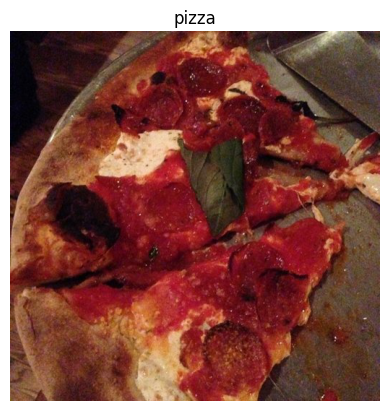

In [5]:
view_random_image(target_dir="10_food_classes_10_percent/train/", target_class="pizza")

## Creating data loaders(preparing the data)
we'll use the `ImageDataGenerator` class to load in our images in batches

In [6]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE =  (224,224)
BATCH_SIZE = (32)

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode= "categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks(things to run whilst our model trains)

Callbacks are extra functionality we can add to models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the Tensorboard callback.
* Model checkpoint with the ModelCheckPoint callback.
* Stopping a model from training (before it trains too long and overfit) with the EarlyStopping callback.

In [7]:
# Create a TensorBoard callback(functionized because we need to create a new one fro each model)
import datetime

def create_tensor_board_callback(dir_name, experiment_name):
  log_dir = dir_name + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving Tensorboard log files to:{log_dir}")
  return tensorboard_callback

**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlowHub

We're going to take majority of model's layers from TensorFlow Hub.

We can access pretrained models on: http://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

**EfficientNet:** EfficientNet is a family of convolutional neural network (CNN) models designed to achieve high accuracy with fewer parameters compared to other architectures. It scales the depth, width, and resolution of the network in a balanced manner, finding an optimal trade-off between model size and performance. EfficientNet models have achieved state-of-the-art results in image classification tasks and are known for their efficiency and effectiveness.

**ResNet:** ResNet, short for Residual Network, is a popular CNN architecture that introduced the concept of residual learning. It addresses the issue of vanishing gradients in deep neural networks by using skip connections, allowing the network to learn residual functions. ResNet architectures come in different depths, such as ResNet-18, ResNet-50, and ResNet-152, with deeper networks achieving higher accuracy. ResNet has been widely used and has significantly contributed to advancements in image recognition tasks.

In [8]:
!pip install --upgrade pip
!pip install --upgrade tensorflow_hub

In [9]:
# let's compare the two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"


In [10]:
# import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
# Let's make a create_model() function to create a model from a Url
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url(str): A TensorFlow Hub feature extraction URL.
        num_classes(int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    #Download the pretrained model and save it as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze the already learned patterns
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [12]:
# Create a model
resnet_model_1 = create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [13]:
# compile the model
resnet_model_1.compile(loss="categorical_crossentropy",
                    optimizer= tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [14]:
history_1 = resnet_model_1.fit(train_data_10_percent,
                          epochs=5,
                          validation_data=(test_data),
                          steps_per_epoch=len(train_data_10_percent),
                          validation_steps=len(test_data),
                          callbacks=[create_tensor_board_callback(dir_name="tensorflow_hub",
                                                                experiment_name="resnet50V2")])

saving Tensorboard log files to:tensorflow_hubresnet50V2/20230706 - 055740
Epoch 1/5
24/24 [==============================] - 34s 888ms/step - loss: 2.1203 - accuracy: 0.3053 - val_loss: 1.3628 - val_accuracy: 0.5584
Epoch 2/5
24/24 [==============================] - 19s 800ms/step - loss: 1.0119 - accuracy: 0.6813 - val_loss: 0.9233 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 18s 773ms/step - loss: 0.6748 - accuracy: 0.8080 - val_loss: 0.8093 - val_accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 19s 790ms/step - loss: 0.5189 - accuracy: 0.8693 - val_loss: 0.7444 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 19s 818ms/step - loss: 0.4174 - accuracy: 0.8960 - val_loss: 0.7254 - val_accuracy: 0.7664


Feature extractor model out performed ALL of the previous models we built by hand..(substantially) and in a quicker training time And with only 10% of the training examples.

In [15]:
resnet_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
# Creating function to plot loss and accuracy curves
import matplotlib.pyplot as plt

def plot_curve(history):
    """
    Returns separate loss curves fro training and validation metrics.

    Args:
        history: TensorFlow History object.

    Return:
        Plots of training/validation loss and accuracy metrics.
    """
    loss = history.history["loss"]
    accuracy = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss)+1 )

    #plot the loss curve
    plt.plot(epochs, loss, 'b', label="Training loss")
    plt.plot(epochs, val_loss, 'r', label= "Validation loss")
    plt.title("Training and Validation loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()

    #plot the accuracy curve
    plt.figure()
    plt.plot(epochs, accuracy, 'b', label="Training accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
    plt.title("Training and Validation accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()

    plt.show()
    plt.clf()

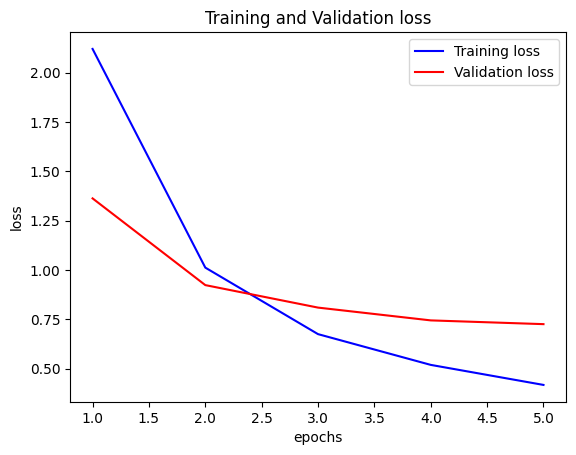

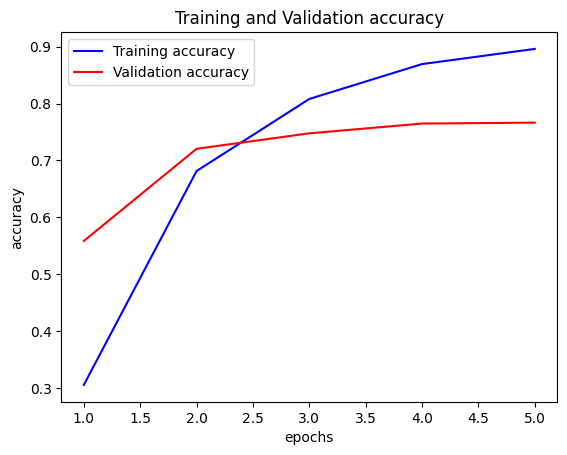

<Figure size 640x480 with 0 Axes>

In [17]:
plot_curve(history_1)

### Creating and testing EfficientnetB0 TensorFlow Hub model

In [18]:
# Create a model
efficientnet_model_1 = create_model(efficientnet_url,
                                   num_classes=train_data_10_percent.num_classes)

In [19]:
#Compile the model
efficientnet_model_1.compile(
            loss="categorical_crossentropy",
            optimizer = tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

In [20]:
# fit the model
history_2 = efficientnet_model_1.fit(train_data_10_percent,
                                    epochs=5,
                                    validation_data=(test_data),
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_steps=len(test_data),
                                    callbacks=[create_tensor_board_callback(dir_name="tensorflow_hub",
                                                                           experiment_name="efficentnetB0")])

saving Tensorboard log files to:tensorflow_hubefficentnetB0/20230706 - 055936
Epoch 1/5
24/24 [==============================] - 24s 822ms/step - loss: 1.8165 - accuracy: 0.4507 - val_loss: 1.2803 - val_accuracy: 0.7448
Epoch 2/5
24/24 [==============================] - 18s 789ms/step - loss: 1.0340 - accuracy: 0.7773 - val_loss: 0.8589 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 17s 740ms/step - loss: 0.7424 - accuracy: 0.8320 - val_loss: 0.6961 - val_accuracy: 0.8468
Epoch 4/5
24/24 [==============================] - 18s 768ms/step - loss: 0.6005 - accuracy: 0.8733 - val_loss: 0.6101 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 18s 767ms/step - loss: 0.5074 - accuracy: 0.8920 - val_loss: 0.5551 - val_accuracy: 0.8612


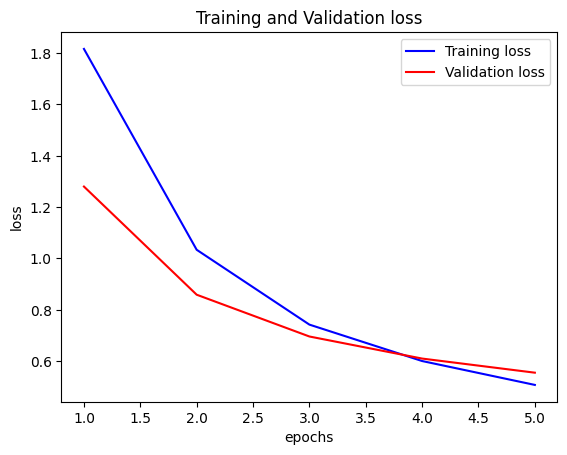

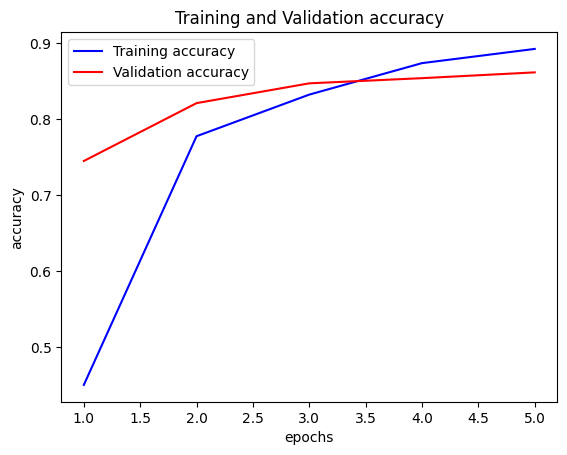

<Figure size 640x480 with 0 Axes>

In [21]:
plot_curve(history_2)

In [22]:
# check summary
efficientnet_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
resnet_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
# how many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model_1.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model(e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for our own problem(e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers(including new output layers)

## Comparing the model results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments(things you don't want others to see) do not upload them to TensorBoard.dev  

In [ ]:
#Uplaoad TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficentNetB0 vs ResNet50V2" \
    --description "Comparing two different TF Hub feature extraction model using 10% of training data"\
    --one_shot

Our TensorBoard experiments are upload publically at: https://tensorboard.dev/experiment/wsPfqO47RqKwYev1rvzDvg/

In [28]:
# Check out what TensorBoard experiments we have
!tensorboard  dev list

2023-07-06 06:14:39.435789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/wsPfqO47RqKwYev1rvzDvg/
	Name                 EfficentNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model using 10% of training data
	Id                   wsPfqO47RqKwYev1rvzDvg
	Created              2023-07-06 06:08:19 (6 minutes ago)
	Updated              2023-07-06 06:08:22 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  3155697
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id wsPfqO47RqKwYev1rvzDvg